In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import kurtosis
from scipy.stats import genpareto
from datetime import datetime
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.linear_model import LinearRegression

In [2]:
Tickers = ['^NSEI', '^GSPC', '^FTSE', '^N225']

In [3]:
end_date = datetime.today()
start_date = end_date - pd.Timedelta(days=10*365)

In [4]:
jpy = pdr.DataReader('DEXJPUS', 'fred', start = start_date, end=end_date)
inr = pdr.DataReader('DEXINUS', 'fred', start = start_date, end=end_date)
gbp = pdr.DataReader('DEXUSUK', 'fred', start = start_date, end=end_date)

In [5]:
df = pd.DataFrame()
for ticker in Tickers:
    ticker_df = yf.download(ticker, start = start_date, end=end_date, auto_adjust = True)
    df = pd.concat([df, ticker_df], axis = 1)






*********************100%***********************]  1 of 1 completed

In [6]:
df = df['Close']
df = pd.concat([df, inr, jpy, gbp], axis=1)

df = df.ffill()
df = df.bfill()

In [7]:
df['^NSEI_D'] = df['^NSEI']/df['DEXINUS']  # inr to dollar (originally 1 dollar to inr rates given)
df['^FTSE_D'] = df['^FTSE']*df['DEXUSUK']  # pound to dollar (originally 1 pound to dollar rates given)
df['^N225_D'] = df['^N225']/df['DEXJPUS']  # yen to dollar (originally 1 dollar to yen rates given)

df = df[['^NSEI_D','^GSPC','^FTSE_D','^N225_D']]

In [8]:
for col in df.columns[::-1]:
    log_return = np.log(df[col]/df[col].shift(1))
    df.insert(df.columns.get_loc(col) + 1, col + '_logret', log_return)

logret_df = df[['^NSEI_D_logret', '^GSPC_logret', '^FTSE_D_logret','^N225_D_logret']]
logret_df = logret_df[1:]

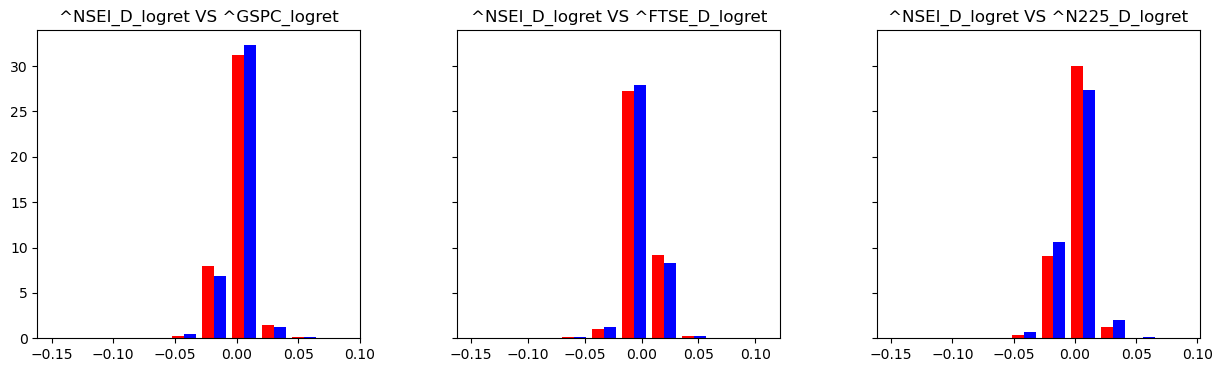

In [9]:
n = len(logret_df.columns)

fig, ax = plt.subplots(1, n-1, sharex = 'col', sharey = 'row', figsize=(15, 4))
colors = ['red', 'blue']

n = 3
axes = ax.flatten()
for i, j in zip(range(n), axes):
    j.hist([logret_df.iloc[:,0], logret_df.iloc[:,i+1]],bins = 10, color = colors, density=True)
    j.set_title(f"^NSEI_D_logret VS {logret_df.columns[i+1][0:]}")

plt.subplots_adjust(wspace=0.3) 
plt.show()

Now we visualize each column of logret_df.

For each column:

- Plot a histogram of the log returns with an overlaid normal distribution curve.

- Plot the empirical cumulative distribution function (ECDF) against the theoretical normal CDF.

Essentially, it’s comparing real data vs. Gaussian model both in histogram form and CDF form for multiple assets/variables.

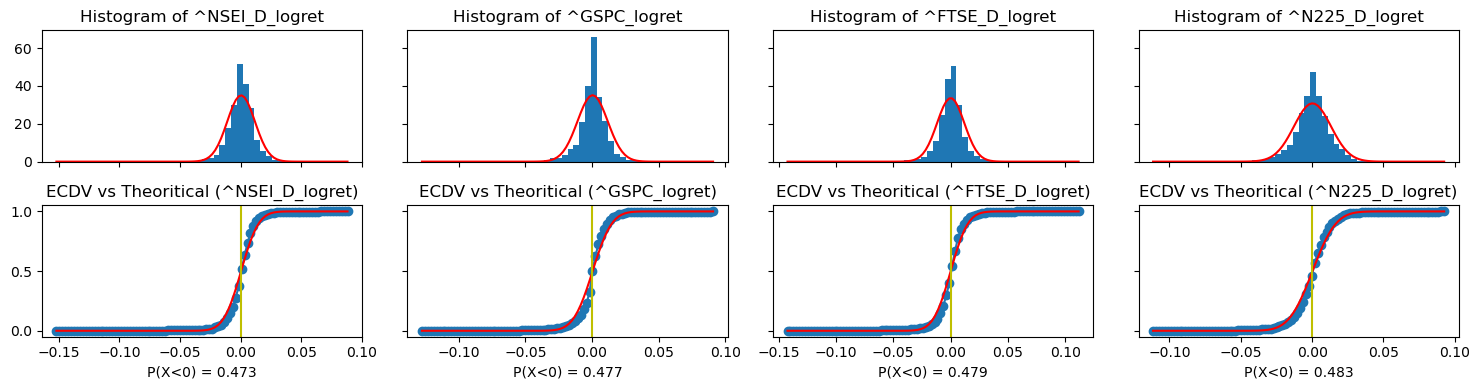

In [10]:
n = len(logret_df.columns)
logret_df_mean = []
logret_df_std = []
fig, ax = plt.subplots(2, n, sharex = 'col', sharey = 'row', figsize = (15, 4))
axes = ax.flatten()
for i, col in enumerate(logret_df.columns):
    fn = ECDF(logret_df[col])
    prob_leq_zero = fn(0)
    
    mu = np.mean(logret_df[col])
    sigma = np.std(logret_df[col])
    
    logret_df_mean.append(mu)
    logret_df_std.append(sigma)
    
    x = np.linspace(min(logret_df[col]), max(logret_df[col]), 100)
    y_pdf = norm.pdf(x, mu, sigma)
    y_cdf = norm.cdf(x, mu, sigma)

    axes[i].plot(x, y_pdf, 'r')
    axes[i].hist(logret_df[col], bins = 50, density=True)
    axes[i].set_title(f"Histogram of {col}")

    axes[i+n].plot(x, fn(x), marker='o') # Plotting the empirical cumulative distribution function of observed data
    axes[i+n].plot(x, y_cdf, 'r') # Plotting the theoritical (normal) cumulative distribution function
    axes[i+n].axvline(0, color='y')
    axes[i+n].set_title(f"ECDV vs Theoritical ({col})")
    axes[i+n].set_xlabel(f"P(X<0) = {prob_leq_zero:.3f}")

plt.tight_layout()
plt.show()

# Below we plot the daily log returns in a QQ plot, comparing the best-fit normal distribution (first row) and the best-fit Student’s t-distribution (second row).

- The t-distribution provides a visibly better fit to the data compared to the normal distribution, especially in the tails.
- The estimated degrees of freedom ($\nu$) for the t-distribution in each case are: $$\nu = 3.349, 1.895, 1.978, 3.517.$$
- Recall that as $\nu \to \infty$, the t-distribution converges to the normal distribution.
- In practice, for $\nu > 30$, the t-distribution is nearly indistinguishable from the normal, while for $\nu \approx 3$ the distribution is heavy-tailed and departs strongly from Gaussian behavior.
- For $1 < \nu < 2$, the t-distribution has a finite mean but infinite theoretical variance.
  - This indicates extreme tail risk: returns are highly sensitive to large, rare shocks.
  - Such behavior is consistent with episodes like the COVID-19 market crash of 2020 and the sharp interest rate hikes of 2022, which caused unusually large daily moves in indices such as the S&P 500 and FTSE 100.

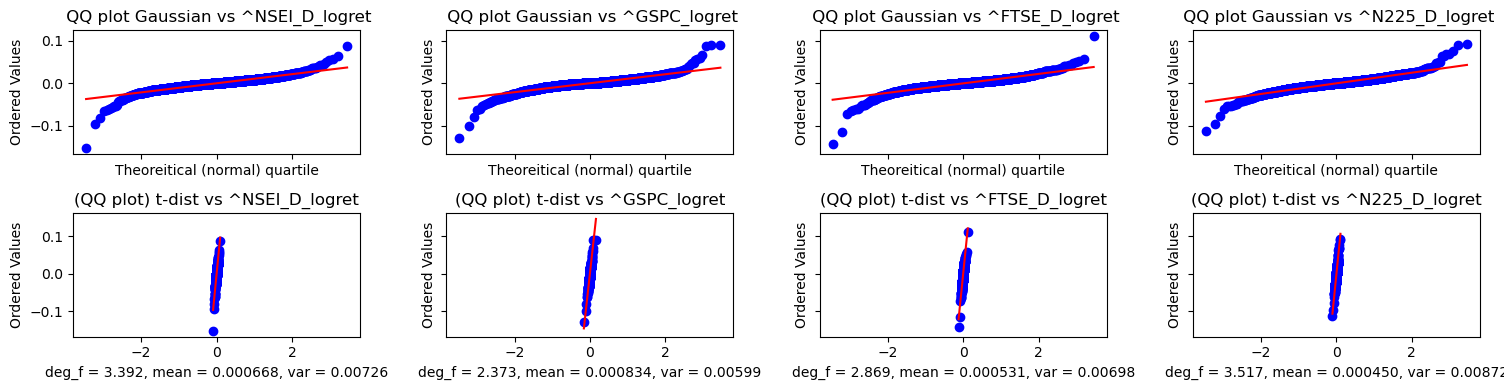

In [11]:
n = len(logret_df.columns)
fig, ax = plt.subplots(2, n, sharex = 'col', sharey = 'row', figsize=(15, 4))
axes = ax.flatten()
logret_df_t_param = []

for i, col in enumerate(logret_df):
    deg_f, loc, scale = stats.t.fit(logret_df[col])
    logret_df_t_param.append([deg_f, loc, scale])

    stats.probplot(logret_df[col], dist='norm', plot=axes[i])
    axes[i].set_title(f" QQ plot Gaussian vs {col}")
    axes[i].set_xlabel('Theoreitical (normal) quartile')

    stats.probplot(logret_df[col], dist=stats.t, sparams = (deg_f, loc, scale), plot=axes[i+n])
    axes[i+n].set_title(f"(QQ plot) t-dist vs {col}")
    axes[i+n].set_xlabel(f"deg_f = {deg_f:.3f}, mean = {loc:.6f}, var = {scale:.5f}")

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()

# Below we plot the daily log-returns on a log-log plot and overlay the normal distribution pdf and t-distribution pdf. 

Methodologies:

- We create a subplot with two rows and four columns. The first row compares the log-log plot of each column in logret_df with the normal pdf, and the second row compares it with the t-distribution pdf.
- For each column, we create a histogram with bins = 50. This splits the data into 50 equal-width intervals, and counts how many points fall into each bin.
- We take x_val as the bin centers (the midpoints between bin edges) and y_val as the counts (frequency densities) for those bins.
- The mean (mu) and standard deviation (sigma) of each column were computed earlier.
- The parameters deg_f, loc (mean), and scale (standard deviation) were obtained by fitting the column data to a t-distribution using stats.t.fit (done in the previous cell).
- Using these parameters, we compute:
    - The t-distribution pdf on x_val
    - The normal distribution pdf on x_val
- In the first row (i = 0, 1, 2, 3), we plot x_val[mask] vs y_val[mask] (where mask = (y_val > 0) ensures only positive values go to the log-y axis) along with the normal pdf.
- In the second row (i + n = 4, 5, 6, 7), we do the same but overlay the t-distribution pdf instead of the normal one.

Conclusion:

- The normal distribution does not capture the heavy tails of the log-return data.
- The t-distribution pdf fits the tails much better.

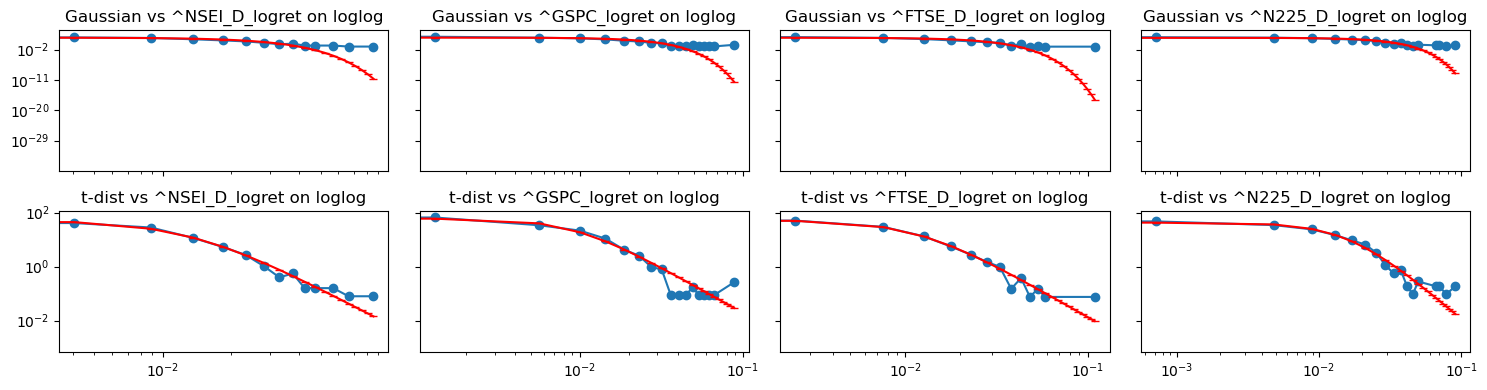

In [12]:
fig, ax = plt.subplots(2, 4, sharex = 'col', sharey = 'row', figsize = (15, 4))
axes = ax.flatten()

for i, col in enumerate(logret_df):
    counts, bins = np.histogram(logret_df[col], bins=50, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    
    mu = logret_df_mean[i]
    sigma = logret_df_std[i]

    x_val = bin_centers
    y_val = counts

    deg_f, loc, scale = logret_df_t_param[i]

    t_pdf_val = stats.t.pdf(x_val, deg_f, loc=loc, scale=scale)
    
    normal_pdf_val = norm.pdf(x_val, loc=mu, scale=sigma)
    mask = (y_val > 0)
    
    
    axes[i].loglog(x_val[mask], y_val[mask], marker='o')
    axes[i].loglog(x_val, normal_pdf_val, marker='_', color = 'r')
    axes[i].set_title(f"Gaussian vs {col} on loglog")

    axes[i+n].loglog(x_val[mask], y_val[mask], marker='o')
    axes[i+n].loglog(x_val, t_pdf_val, marker='_', color='r')
    axes[i+n].set_title(f"t-dist vs {col} on loglog")

plt.tight_layout()
plt.show()

# Below we compute the kurtosis and skewness of the daily log-returns.

Methodology:

- First, we calculate the kurtosis of each column in logret_df using the DataFrame.kurt() method along axis = 0. This gives the excess kurtosis (kurtosis minus 3), which helps identify whether the data is heavier-tailed (leptokurtic) or lighter-tailed (platykurtic) than a normal distribution.
- We drop all NaN values from logret_df to ensure accurate statistical calculations.
- Let n_rows be the total number of observations in the cleaned dataset.
- To compute the skewness manually for each column:
    - We first compute the sample mean (mu_col) and standard deviation (std_col).
    - We then apply the formula for sample skewness (bias-corrected): $$ \frac{n_{rows}}{(n_{rows}-1)(n_{rows}-2)} \sum\limits_{i=1}^{n_{rows}}\frac{(logret_{df}[col] - mu_{col})}{std_{col}}^3$$
    - This is implemented in the loop, where we append the skewness value for each column into the skewness dictionary.

Conclusion:

- Kurtosis tells us about the tail heaviness of returns relative to normal.
- Skewness reveals whether returns are tilted more to the left (negative skew) or to the right (positive skew).
- Both metrics help confirm the non-normal nature of financial return distributions.

In [13]:
logret_df_kurt = logret_df.kurt(axis=0)  # To compute the kurtosis of the dataframe

logret_df = logret_df.dropna()  
n_rows = len(logret_df)

skewness = {m : [] for m in logret_df.columns}

for i, col in enumerate(logret_df):
    mu_col = np.mean(logret_df[col])
    std_col = np.std(logret_df[col])

    skewness[col].append(n_rows/((n_rows-1) * (n_rows-2)) * np.sum(((logret_df[col] - mu_col)/std_col)**3))       # To compute the skewness

# Generalized Pareto Distribution

- The probability density function of generalized pareto distribution is given by $$F(y) = 1 - (1 + \xi \frac{y}{\beta})^{-\frac{1}{\xi}}, \quad \quad (y \geq 0)$$
    - Here $y = x - u$ denotes the excess over threshold $u$.
    - $\xi$ quantifies the heaviness of tail.
        - $\xi > 0$ implies heavy tail (for example stock returns)
        - $\xi = 0$ implies exponential tail
        - $\xi < 0$ implies upper-bounded tail
    - $\beta$ measures the spread of extreme i.e., tail.

In [39]:
l_results = {}

for col in logret_df.columns:
    l_values = np.linspace(np.quantile(-logret_df[col], 0.10),
                          np.quantile(-logret_df[col], 0.95),
                          100)

    l_xi_values = []
    l_beta_values = []
    mrl_l_val = []

    for l in l_values:
        l_exceed = (-logret_df[col][-logret_df[col] > l]) - l
        mrl_val = np.mean(l_exceed)

        if len(l_exceed) > 0:
            xi, loc, beta = genpareto.fit(l_exceed, floc=0)
        else:
            xi, loc, beta = np.nan, 0, np.nan

        l_xi_values.append(xi)
        l_beta_values.append(beta)
        mrl_l_val.append(mrl_val)

    l_results[col] = pd.DataFrame({'l_val' : l_values,
                                  'l_xi_val' : l_xi_values,
                                  'l_beta_val' : l_beta_values,
                                  'mrl_l_val' : mrl_l_val})
GPD_l_df = pd.concat(l_results, axis=1)

In [15]:
u_results = {}

for col in logret_df.columns:
    u_values = np.linspace(np.quantile(logret_df[col], 0.10),
                          np.quantile(logret_df[col], 0.95),
                          100)
    u_xi_values = [] 
    u_beta_values = []
    mrl_u_val = []
    
    for u in u_values:
        u_exceed = logret_df[col][logret_df[col] > u] - u
        mrl_val = np.mean(u_exceed)
        
        if len(u_exceed) > 0:
            xi, loc, beta = genpareto.fit(u_exceed, floc=0)
        else:
            xi, loc, beta = np.nan, 0, np.nan
        
        u_xi_values.append(xi)
        u_beta_values.append(beta)
        mrl_u_val.append(mrl_val)

    u_results[col] = pd.DataFrame({'u_val': u_values,
                                'u_xi_val': u_xi_values,
                                'u_beta_val':u_beta_values,
                                  'mrl_u_val' : mrl_u_val})
GPD_u_df = pd.concat(u_results, axis=1)

# Analysis of $\beta(u)$ as a function of threshold $u$:

From the Extreme Value Theory, the spread i.e, $\beta$ as a function of $u$ measures the variance of the tail i.e, of values beyond u. Interpretaion of $\beta(u)$,

- For lower values of $u$, a larger portion of data lies beyond the threshold, leading to higher variability in the tail. Hence, $\beta$ is relatively large.
- As $u$ increases, fewer data points exceed the threshold, and the variance of exceedances reduces. This drives $\beta$ downward.
- Consequently, the curve of $u \mapsto \beta(u)$ is typically of downward slope.
- The key objective is to identify a threshold $u_0$, beyond which $\beta$ stabilizes (i.e., the curve becomes approximately flat, with no significant curvature). Stability of $\beta$ is an indicator of a suitable threshold.

From the plots below, we observe that for NSEI, GSPC, and FSTS, stabilization occurs around $u \approx 0.010$. For N225, the stabilization appears at a slightly higher threshold.

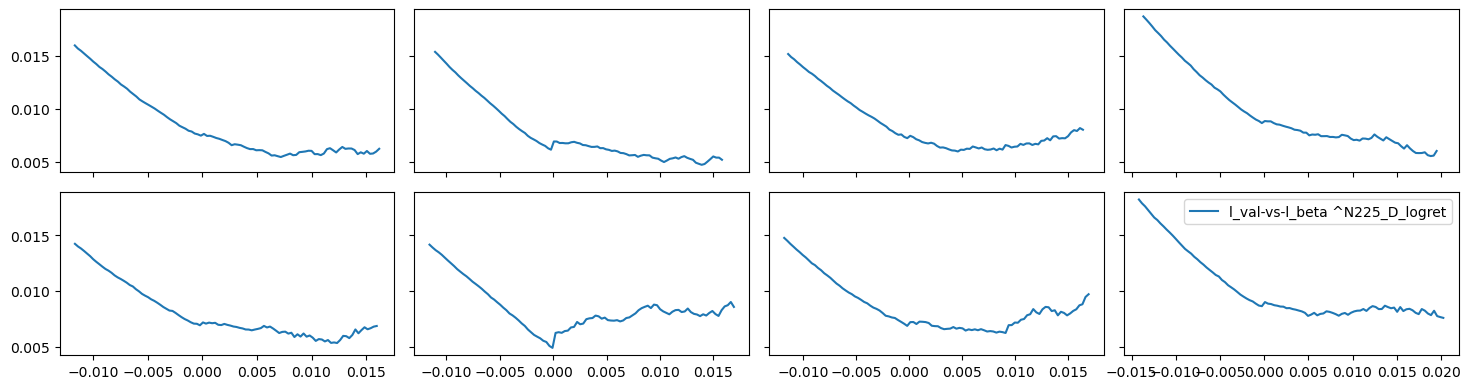

In [21]:
fig, ax = plt.subplots(2, 4, sharex = 'col', sharey = 'row', figsize = (15, 4))
axes = ax.flatten()

for i, col in enumerate(logret_df):
    u_values = GPD_u_df[col, 'u_val']
    u_beta_values = GPD_u_df[col]['u_beta_val']

    l_values = GPD_l_df[col, 'l_val']
    l_beta_values = GPD_l_df[col]['l_beta_val']
    
    axes[i].plot(u_values, u_beta_values, label=f'u_val-vs-u_beta {col}')
    axes[i+4].plot(l_values, l_beta_values, label=f"l_val-vs-l_beta {col}")
plt.legend()
plt.tight_layout()
plt.show()

# Analysis of $\xi(u)$ as a function of threshold $u$:

In Extreme Value Theory, the shape parameter $\xi$ governs the heaviness of the tail and thus provides critical information about the distribution of extreme events. Interpreting $\xi(u)$:

- For lower thresholds $u$the estimate of $\xi(u)$ is often unstable because the exceedances include too many “non-extreme” values.
- As $u$ increases, the estimates begin to reflect the true tail behavior more accurately.
- Ideally, we look for a region of stability where $\xi(u)$ levels off, since this indicates that the Generalized Pareto fit has become robust to further increases in $u$.
- If $\xi(u)$ continues to fluctuate strongly, it suggests that the chosen threshold may not be high enough (or that more data is needed).

From the plots below, we see that for NSEI, GSPC, and FSTS, $\xi(u)$ becomes relatively stable around $u \approx 0.010$. For N225, stabilization occurs at a somewhat higher threshold, consistent with the behavior observed in $\beta(u)$.

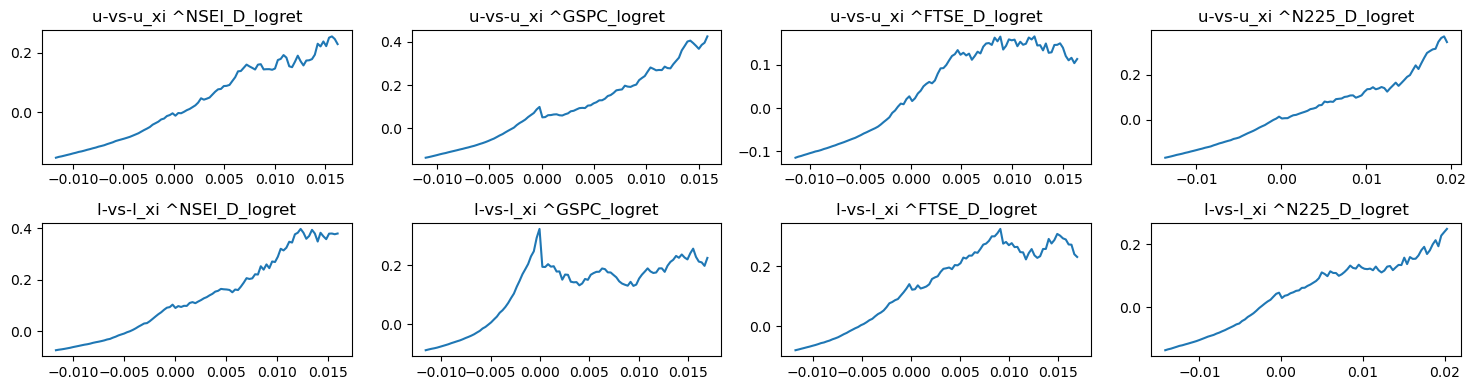

In [26]:
fig, ax = plt.subplots(2, 4, figsize = (15, 4))
axes = ax.flatten()

for i, col in enumerate(logret_df):
    u_values = GPD_u_df[col, 'u_val']
    u_xi_values = GPD_u_df[col, 'u_xi_val']

    l_values = GPD_l_df[col, 'l_val']
    l_xi_values = GPD_l_df[col, 'l_xi_val']
    
    axes[i].plot(u_values, u_xi_values, label=f'u-vs-u_xi {col}')
    axes[i].set_title(f"u-vs-u_xi {col}")
    axes[i+4].plot(l_values, l_xi_values, label=f"l_val-vs-l_xi_val {col}")
    axes[i+4].set_title(f"l-vs-l_xi {col}")
plt.tight_layout()
plt.show()

# Analysis on Mean Residual Life (MRL) plots:

- The Mean Residual Life (MRL) function, defined as the expected excess above a threshold $u$ plays a central role in threshold selection for the Generalized Pareto Distribution (GPD). Its behavior provides diagnostic evidence for where the GPD approximation becomes valid.

- For low thresholds $u$, the MRL curve is typically curved, reflecting bias from including too many central (non-extreme) data points.

- As the threshold increases, the MRL plot should become approximately linear, which indicates that the exceedances follow the GPD model.

- The slope of this line is directly linked to the shape parameter $\xi$, while the intercept corresponds to the scale parameter $\beta$.

- Thus, the region where the MRL plot straightens is crucial for selecting the appropriate threshold $u_0$.

From the analysis below, we observe that for NSEI, GSPC, and FSTC, the MRL curves approach linearity at thresholds around $u≈0.010$, consistent with the earlier conclusions from $\beta(u)$ and $\xi(u)$. For N225, the transition to linearity occurs at a slightly higher threshold, again indicating heavier or more complex tail behavior relative to the other indices.

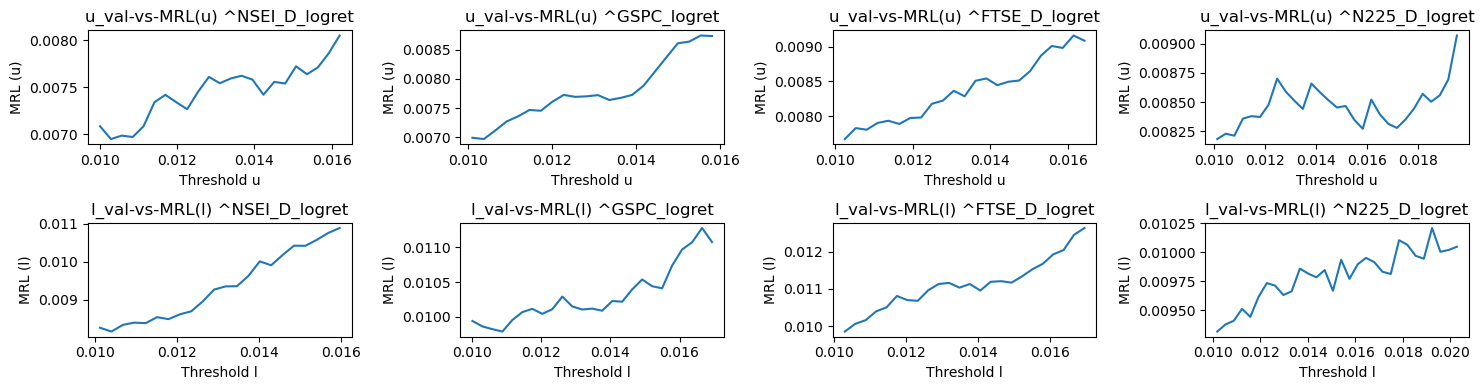

In [50]:
fig, ax = plt.subplots(2, 4, figsize = (15, 4))
axes = ax.flatten()

for i, col in enumerate(logret_df):
    
    u_values = GPD_u_df[col, 'u_val']
    mrl_u_values = GPD_u_df[col, 'mrl_u_val']

    l_values = GPD_l_df[col, 'l_val']
    mrl_l_values = GPD_l_df[col, 'mrl_l_val']

    u_bdry = 0.010
    u_mask = u_values > u_bdry

    l_bdry = 0.010
    l_mask = l_values > l_bdry

    u_xi, u_loc, u_beta = genpareto.fit((logret_df[col][logret_df[col] > u_bdry] - u_bdry))
    l_xi, l_loc, l_beta = genpareto.fit((-logret_df[col][-logret_df[col] > -l_bdry] - l_bdry))
    #line_col = (beta + xi*(u_values - u_bdry))/(1 - xi)


    #print(f"xi, loc and beta for the MRL of {col} are {xi:.5f}, {loc:.5f}, and {beta:.5f} respectively")
    
    axes[i].plot(u_values[u_mask], mrl_u_values[u_mask], label = f"Upper_MRL plot for {col}")
    axes[i].set_title(f"u_val-vs-MRL(u) {col}")
    axes[i].set_xlabel(f'Threshold u')
    axes[i].set_ylabel('MRL (u)')

    axes[i+4].plot(l_values[l_mask], mrl_l_values[l_mask], label = f"Lower_MRL plot for {col}")
    axes[i+4].set_title(f"l_val-vs-MRL(l) {col}")
    axes[i+4].set_xlabel(f"Threshold l")
    axes[i+4].set_ylabel("MRL (l)")

plt.tight_layout()
plt.show()

# Analysis on MRL plots with linear regression fit:

- The Mean Residual Life (MRL) plots were refined by applying a linear regression fit to the empirical MRL curves. This approach provides a quantitative check for the threshold stability.

- For each index, the MRL plot shows a curved region at low thresholds, indicating bias due to the breakdown of the GPD asymptotics.

- Above the boundary threshold $u=0.006$, the MRL functions become approximately linear, and the regression fit captures this stability.

- The slope of the regression line corresponds to the estimated shape parameter $\xi$ while the intercept corresponds to the scale parameter $\beta$.

- For NSEI, GSPC, and FSTC, the empirical MRL aligns well with the regression fit above the threshold, confirming the suitability of the chosen boundary.

- For N225, the fit shows stronger deviations, suggesting heavier tails and the need for a slightly higher threshold for robust GPD modeling.

These regression-enhanced MRL plots strengthen the diagnostic evidence for selecting thresholds and highlight differences in tail heaviness across indices.

In [52]:
def plot_mrl_with_reg_fit(thresholds, mrl_values, title, ax):
    thresholds = thresholds.values.reshape(-1,1)
    mrl_values = mrl_values.values.reshape(-1,1)

    model = LinearRegression().fit(thresholds, mrl_values)
    mrl_modle_val = model.predict(thresholds)

    ax.plot(thresholds, mrl_values, label='Empirical MRL')
    ax.plot(thresholds, mrl_modle_val, label = 'Lin-reg-MRL-fit')
    ax.set_title(title)
    ax.set_xlabel('Threshold (u)')
    ax.set_ylabel('MRL (u)')
    ax.legend()

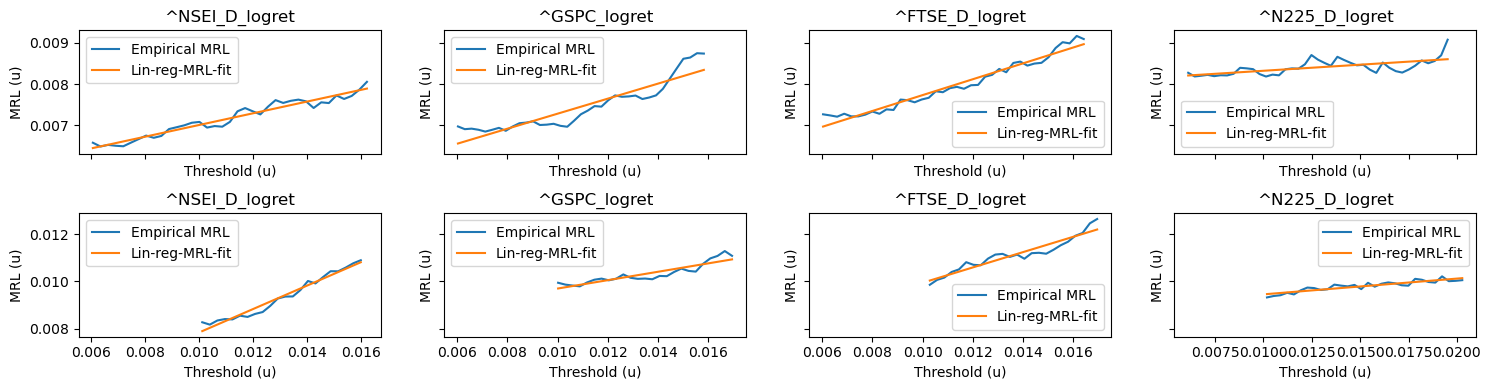

In [61]:
fig, ax = plt.subplots(2, 4, sharex = 'col', sharey = 'row', figsize = (15, 4))
axes = ax.flatten()

for i, col in enumerate(logret_df):
    u_values = GPD_u_df[col, 'u_val']
    mrl_u_values = GPD_u_df[col, 'mrl_u_val']

    l_values = GPD_l_df[col, 'l_val']
    mrl_l_values = GPD_l_df[col, 'mrl_l_val']

    u_bdry = 0.006
    u_mask = u_values > u_bdry

    l_bdry = 0.010
    l_mask = l_values > l_bdry

    plot_mrl_with_reg_fit(u_values[u_mask], mrl_u_values[u_mask], col, axes[i])
    plot_mrl_with_reg_fit(l_values[l_mask], mrl_l_values[l_mask], col, axes[i+4])
plt.tight_layout()
plt.show()

# Value at Risk

$${\rm VaR}_p = u + \frac{\beta}{\xi}((\frac{N_u}{n(1-p)})^{\xi} - 1)$$

In [69]:
var = {}
p = 0.95 # confidence interval
u_loc = 80
l_loc = 80

for col in logret_df.columns:
    u = GPD_u_df[col, 'u_val'][u_loc]
    xi = GPD_u_df[col, 'u_xi_val'][u_loc]
    beta = GPD_u_df[col, 'u_beta_val'][u_loc]
    n = len(logret_df[col])
    N_u = len(logret_df[col][logret_df[col] > u])
    
    if xi != 0:
        var_p = u + beta/xi*((N_u/(n*(1-p)))**xi - 1)
    else:
        var_p = u + beta * np.log(N_u / (n * (1 - p)))

    var[col] = pd.Series({'u_val' : u,
                          'confidence interval' : p,
                              'N_u' : N_u,
                              'Var_p' : var_p})
VAR_df = pd.DataFrame(var).T

In [70]:
VAR_df

,u_val,confidence interval,N_u,Var_p
^NSEI_D_logret,0.010851,0.95,309.0,0.016133
^GSPC_logret,0.010659,0.95,311.0,0.015684
^FTSE_D_logret,0.011089,0.95,284.0,0.016638
^N225_D_logret,0.013150,0.95,296.0,0.019422


# Include the lower tail part as well in the above cell.

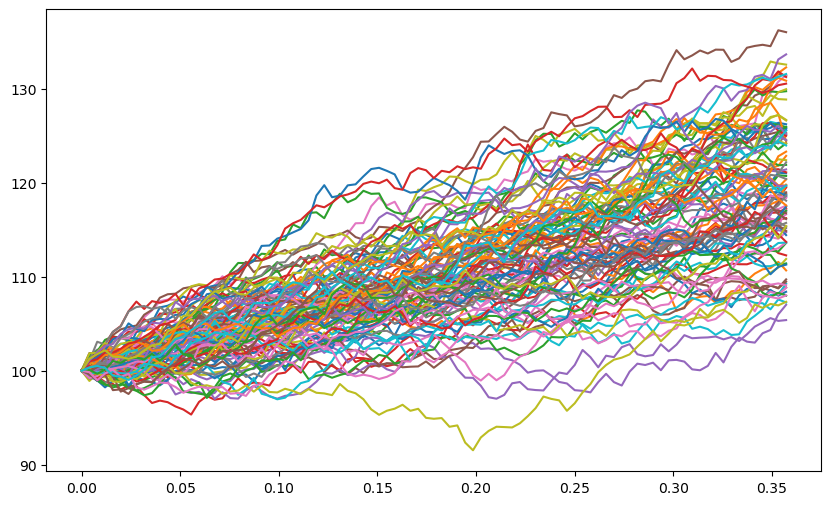

In [16]:
Num_of_days = 90 # trying to find stock price
dt = 1/252
sigma = 0.1
mu = 0.5
S0 = 100
Num_sim = 100
asset_paths = []


T = np.linspace(0, Num_of_days * dt, Num_of_days + 1) # my time steps
for _ in range(Num_sim):
    Z = np.random.standard_normal(size = Num_of_days) * np.sqrt(dt)
    Brownian_motion_path = np.cumsum(np.insert(Z, 0, 0))
    asset_path = S0 * np.exp((mu - 0.5*sigma**2)*T + sigma * Brownian_motion_path) # exp(mu - 0.5 * sigma**2) + sigma * dW_t
    asset_paths.append(asset_path)
plt.figure(figsize=(10, 6))
for path in asset_paths:
    plt.plot(T, path)
plt.show()